# Time Series: Weather Data

Data from https://www.ecad.eu/

In [1]:
from copy import copy

import pandas as pd
import numpy as np
from scipy.io import wavfile

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Ridge, Lasso
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## Data

In [2]:
filepath = "../data/ECA_blended_custom/TG_STAID002759.txt"

The file header states
* "MISSING VALUE CODE IS -9999"
* "mean temperature in 0.1 °C"

In [3]:
df = pd.read_csv(filepath
                 ,skiprows = 19 # skip info lines above csv part
                 ,skipinitialspace = True # to get clean column names
                 ,na_values = [-9999])
df.rename(mapper={'DATE':'Date', 'TG':'Temperature', 'Q_TG':'Quality', 'SOUID':'Sensor ID'}, axis=1, inplace=True)

In [4]:
# datetime format string doc: https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior
df['Date'] = pd.to_datetime(df['Date'], format="%Y%m%d")
df.set_index('Date', inplace=True)

In [5]:
df['Temperature'] = 0.1 * df['Temperature']

In [6]:
df.head()

,Sensor ID,Temperature,Quality
Date,,,
1876-01-01,127488,2.2,0
1876-01-02,127488,2.5,0
1876-01-03,127488,0.3,0
1876-01-04,127488,-5.8,0
1876-01-05,127488,-9.8,0


## Explore
*https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html#indexing*

### One year of the data set

<AxesSubplot:xlabel='Date', ylabel='Temperature'>

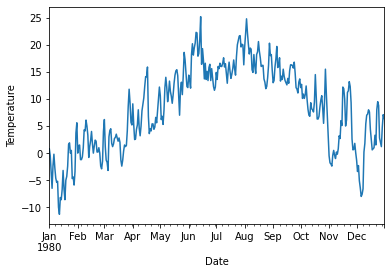

In [7]:
df.loc['1980','Temperature'].plot(ylabel='Temperature')

### All years in one plot

*https://atedstone.github.io/pandas-plot-seasons-time-series/*

In [8]:
df['Day of Year'] = df.index.dayofyear
df['Year'] = df.index.year
piv = pd.pivot(df, index='Day of Year', columns='Year', values='Temperature')

<AxesSubplot:xlabel='Day of Year', ylabel='Temperature'>

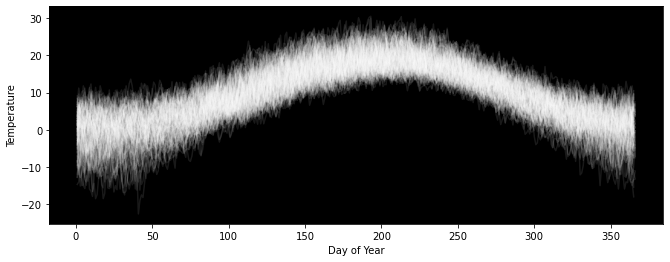

In [9]:
fig, ax = plt.subplots(figsize=(11,4))
ax.set_facecolor('k')
piv.plot(kind='line', c='white', alpha=0.1, ax=ax, legend=False, ylabel='Temperature')

### Time Series Historgram

Alternatives
* `sns.displot(data=df, y='TG', x='Day of Year')`
* The hard way: https://matplotlib.org/stable/gallery/statistics/time_series_histogram.html

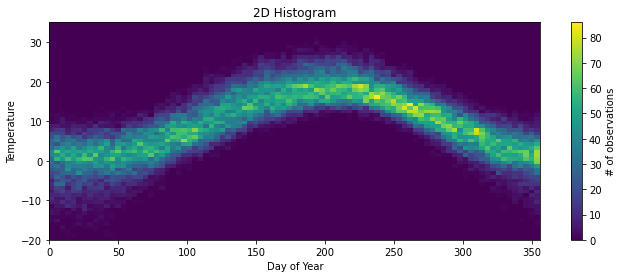

In [10]:
fig, ax = plt.subplots(figsize=(11,4))
_, _, _, im = ax.hist2d(data=df, y='Temperature', x='Day of Year'
              ,bins=[int(356/4), 60], range=[[0,356],[-20,35]])
ax.set_title('2D Histogram')
ax.set_ylabel('Temperature')
ax.set_xlabel('Day of Year')
fig.colorbar(im, ax=ax, label="# of observations")

Around day 250 we see bright spots. This is because the distribution is narrower at this region. As a result more observations are mapped to the same 2D-bin.

### All years with standard deviation band

<AxesSubplot:xlabel='Day of Year', ylabel='Temperature'>

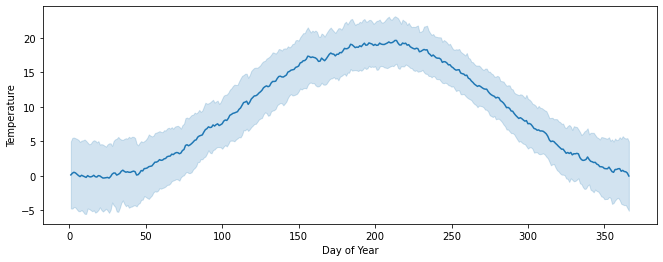

In [11]:
fig, ax = plt.subplots(figsize=(11,4))
sns.lineplot(data=df, x="Day of Year", y="Temperature", ci='sd', ax=ax)

### Heatmap

<AxesSubplot:title={'center':'NaN'}, xlabel='Year', ylabel='Day of Year'>

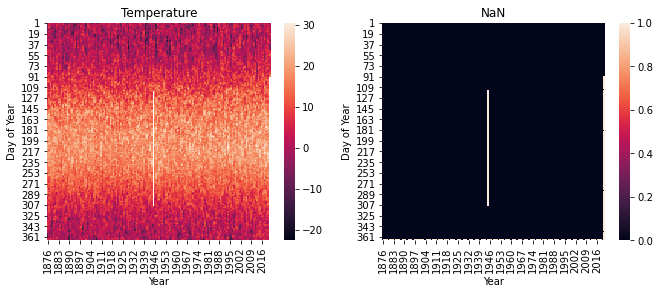

In [12]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(11,4))
ax1.set_title('Temperature')
sns.heatmap(piv, ax=ax1)
ax2.set_title('NaN')
sns.heatmap(piv.isna(), ax=ax2)

### Soification

Further info on data sonification (NASA, CERN):
* https://www.nasa.gov/mission_pages/chandra/news/data-sonification-a-new-cosmic-triad-of-sound.html
* https://www.youtube.com/watch?v=1VS9Od9qM1k
* https://www.youtube.com/watch?v=Ocq3NeudsVk

Preprocessing

In [13]:
# make sure samples/observations are in the right order
df.sort_index(inplace=True)
samples = df['Temperature'].to_numpy(dtype=np.float64)

In [14]:
# replace NaN with zero values
np.nan_to_num(samples, nan=0.0, copy=False)

# Normalization: Floating point wave files have to have a value range from -1 to +1
def normalize(x): return (x-min(x))/(max(x)-min(x)) # normalizes to [0,1]
samples = 2.0*normalize(samples) - 1.0

In [15]:
wavfile.write('./sound/all_slow.wav',   5_000, samples)
wavfile.write('./sound/all_fast.wav', 100_000, samples)

*To convert the WAVE files to a more common format use `sox input.wav -r 44100 -b 16 output.wav`*

### Further Exploration Ideas:
* https://seaborn.pydata.org/examples/kde_ridgeplot.html
* 3D surface plot of Heatmap

## Choose data

Use an excerpt without missing values.

In [16]:
df_copy = df

In [17]:
df = pd.DataFrame(df_copy.loc['1960':'1980'])

<AxesSubplot:xlabel='Date', ylabel='Temperature'>

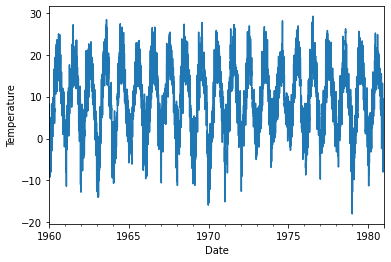

In [18]:
df.Temperature.plot(ylabel='Temperature')

## Statistical Signal Processing Intermezzo: Frequency Analysis

Periodogram approximating the Power Spectral Density

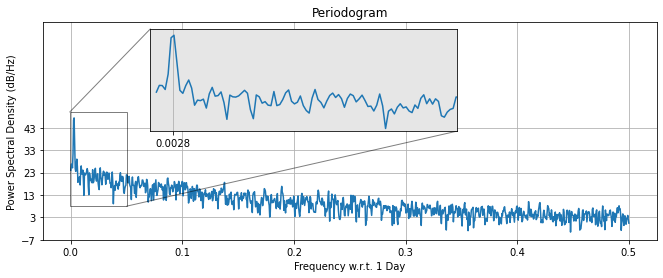

In [19]:
fig, ax = plt.subplots(figsize=(11,4))
psd_kwargs = dict(detrend='linear', NFFT=2**11, Fs=1)
ax.psd(df['Temperature'], **psd_kwargs)
ax.set_xlabel('Frequency w.r.t. 1 Day')
ax.set_ylim(top=90)
ax.set_title('Periodogram')

# https://matplotlib.org/stable/gallery/subplots_axes_and_figures/zoom_inset_axes.html
axins = ax.inset_axes([0.175, 0.5, 0.5, 0.47])
axins.psd(df['Temperature'], **psd_kwargs)
axins.set_xlim(-0.001,0.05); axins.set_ylim(8,50)
axins.set_xlabel('')
axins.set_ylabel('')
axins.set_yticks([])
axins.set_yticklabels('')
axins.set_xticks([1/356])
axins.set_xticklabels(['0.0028'])
axins.set_facecolor('0.9')
ax.indicate_inset_zoom(axins, edgecolor="black")
pass # suppress jupyter output

* Sampling Frequency Fs = 1 Day
* Year Frequency = 1/356 = 0.0028 Cycles per Day
* No harmonics can be seen meaning that the seasonality is purely sinusoidal

## Time Series Modelling

In [20]:
m = Ridge(alpha=0.5)
#m = Lasso(alpha=0.5)
#m = LinearRegression()

In [21]:
# Handling time with pandas
#     big thanks to https://stackoverflow.com/a/28783971
#     Note: https://stackoverflow.com/a/49869631 and https://github.com/pandas-dev/pandas/issues/15303#issuecomment-277401817
#     frequency aliases https://pandas.pydata.org/docs/user_guide/timeseries.html#timeseries-offset-aliases
df.index.to_period('M').to_timestamp()
df.index - df.index.to_period('M').to_timestamp()
pass

### Model the linear overall trend by providing timestamp as a feature

In [22]:
df['Timestamp'] = df.index.astype('int64')

### Model the seasonality (year)

As ordinal feature with polynomial expansion to the 5th degree

In [23]:
df['Day of Year']   = df.index.dayofyear
df['Day of Year^2'] = df.index.dayofyear**2
df['Day of Year^3'] = df.index.dayofyear**3
df['Day of Year^4'] = df.index.dayofyear**4
df['Day of Year^5'] = df.index.dayofyear**5

In [24]:
feature_list = ['Timestamp'
                , 'Day of Year', 'Day of Year^2', 'Day of Year^3'
                , 'Day of Year^4', 'Day of Year^5']
X = df[feature_list]
y = df['Temperature']
m.fit(X, y)
df['Model 1'] = m.predict(X)

/Users/raphael/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=2.36026e-34): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


<AxesSubplot:xlabel='Date'>

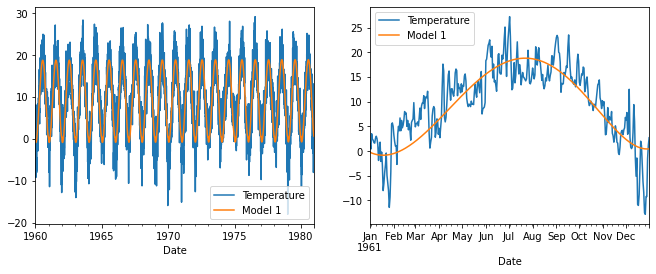

In [25]:
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
df[['Temperature', 'Model 1']].plot(ax=ax[0])
df.loc['1961',['Temperature', 'Model 1']].plot(ax=ax[1])

* Ridge regression did a better job (than unregularized regression) in terms of modelling the seasonality in the beginning of a year where the temperature is still dropping.
* Lasso (at lambda=0.5) didn't result in a sinusoidal nature. Lowering the reugularization weight could've solved this.

### Manual Auto Regressive (AR) Model

Extract remainder

<AxesSubplot:xlabel='Date'>

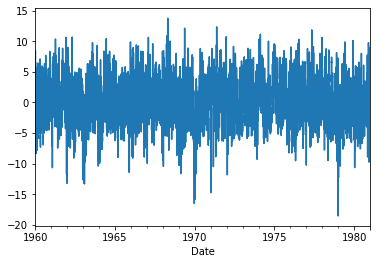

In [26]:
df['Remainder'] = df['Temperature'] - df['Model 1']
df['Remainder'].plot()

Looks stationary. Use partial autocorrelation to choose lags.

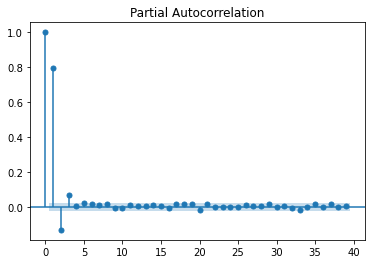

In [27]:
plot_pacf(df['Remainder'])
pass

With Box-Jenkins method lags 1,2,3 should be used here.

In [28]:
df['lag1'] = df['Remainder'].shift(1, fill_value=0.0)
df['lag2'] = df['Remainder'].shift(2, fill_value=0.0)
df['lag3'] = df['Remainder'].shift(3, fill_value=0.0)

In [29]:
df[['Temperature','Remainder','lag1','lag2','lag3']].head()

,Temperature,Remainder,lag1,lag2,lag3
Date,,,,,
1960-01-01,6.4,6.670840,0.000000,0.000000,0.000000
1960-01-02,8.1,8.438853,6.670840,0.000000,0.000000
1960-01-03,5.4,5.802423,8.438853,6.670840,0.000000
1960-01-04,3.9,4.361590,5.802423,8.438853,6.670840
1960-01-05,6.0,6.516392,4.361590,5.802423,8.438853


In [30]:
# Fit model with lags
feature_list.extend(['lag1','lag2','lag3'])
X = df[feature_list]
y = df['Temperature']
m.fit(X, y)
df['Model 2'] = m.predict(X)

/Users/raphael/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_ridge.py:147: LinAlgWarning: Ill-conditioned matrix (rcond=3.89705e-35): result may not be accurate.
  return linalg.solve(A, Xy, sym_pos=True,


<AxesSubplot:xlabel='Date'>

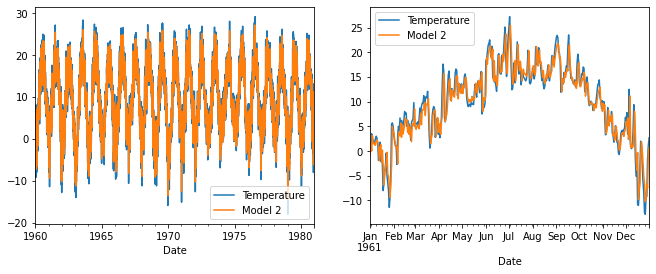

In [33]:
fig, ax = plt.subplots(ncols=2, figsize=(11,4))
df[['Temperature', 'Model 2']].plot(ax=ax[0])
df.loc['1961',['Temperature', 'Model 2']].plot(ax=ax[1])